# Example use case of the WMMD

This notebook provides a simple use case of the Weighted Maximum Mean Discrepancy for testing equality between distributions observed with bias, based on our paper *"A fair Kernel Two Sample Test"*.

## What is the Weighted Maximum Mean Discrepancy test?

The two-sample problem considers testing whether two independent samples are likely drawn from the same distribution. Conventional tests, however, may inherit systematic biases embedded in the data collection mechanism - that leads, for example, to some instances being more likely included in our sample - and may reproduce unfair or confounded decisions. The hypothesis testing problem is formulated in a conventional manner as evaluating the evidence for, $\mathcal H_0: P=Q \quad\text{versus}\quad \mathcal H_1: P\neq Q$, but, unlike conventional two-sample problems, with biased data we assume access to distributions $P$ and $Q$ only via an (unknown) sampling policy $T$, rather than directly through independent samples from $P$ and $Q$. To make the problem identifiable, we assume $T$ is dependent only on observed confounders - that is, an additional set of variables $X$, for both populations that both influences the distributions $P$ and $Q$, and influences $T$,

To solve this problem, we propose a two-sample test that adjusts for differences in marginal distributions of confounding variables. Our test statistic is a weighted distance between samples embedded in a reproducing kernel Hilbert space, whose balancing weights correct for bias due to confounding or protected variables.

Let us import some necessary packages before illustrating this problem with a simple example.

In [ ]:
import sys
print(sys.path)
sys.path.append('c:\\users\\abellot\\appdata\\local\\programs\\python\\python36\\library\\bin')

In [2]:
%matplotlib inline
import numpy as np
import general_utils as general_utils
import data as data
import kernel_utils as kernel_utils
import test_utils as tst
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Simple first example
Let us start by simulating some data in a way that the distributions *p(y|x)* agree in the two populations but there is covariate shift (*p(x)* different *q(x)*) which masks this relationships when observed side by side.

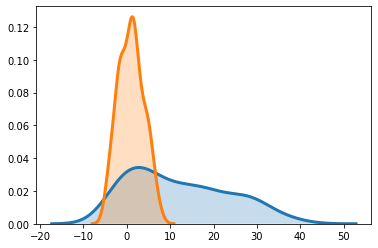

In [3]:
x = 11 * np.random.random(200) - 6.0 # x lies in [-6,5]
#x = 5 * np.random.normal(5, 1.0,size=200) - 6.0
y = x ** 2 + 10 * np.random.random(200) - 5
x1 = np.c_[x, y]

x = 2 * np.random.random(200) - 2.0 # x lies in [-2,0]
#x = 2 * np.random.normal(5, 1.0,size=200) - 2.0
y = x ** 2 + 10 * np.random.random(200) - 5
x2 = np.c_[x, y]

# Draw the density plot
sns.distplot(x1[:, 1], hist = False, kde = True,
             kde_kws = {'shade': True,'linewidth': 3})
sns.distplot(x2[:, 1], hist = False, kde = True,
             kde_kws = {'shade': True,'linewidth': 3})


Here we see that the two distributions look very different, but do they actually if we restrict our problem to areas of overlapping support?

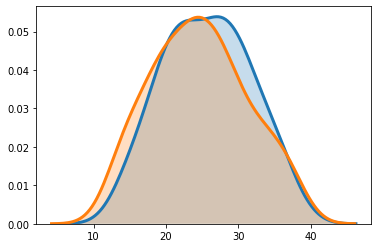

In [4]:
x = 2 * np.random.random(200) - 6.0 # x lies in [-6,5]
#x = 2 * np.random.normal(5, 1.0,size=200) - 6.0
y = x ** 2 + 10 * np.random.random(200) - 5
x1_bis = np.c_[x, y]

x = 2 * np.random.random(200) - 6.0 # x lies in [-6,-4]
#x = 2 * np.random.normal(5, 1.0,size=200) - 6.0
y = x ** 2 + 10 * np.random.random(200) - 5
x2_bis = np.c_[x, y]

# Draw the density plot
sns.distplot(x1_bis[:, 1], hist = False, kde = True,
             kde_kws = {'shade': True,'linewidth': 3})
sns.distplot(x2_bis[:, 1], hist = False, kde = True,
             kde_kws = {'shade': True,'linewidth': 3})

Notice that difference in the generating processes is not as obvious anymore. The actually agree after correcting for distributional shift in confounding variables.

### Now, can we say formally and automatically whether there is a difference in generating processes after adjusting for confounders?

To answer this question, we developed the WMMD which proceeds by re-weighting the MMD to correct for distributional shift by mathcing confounding distributions in Hilbert space.

Below, we illustrate Kernel mean matching to show that indeed it recognises areas of overlapping support and assigns more weight to these areas for the final decision on the hypothesis testing problem.

7.1157498974882545


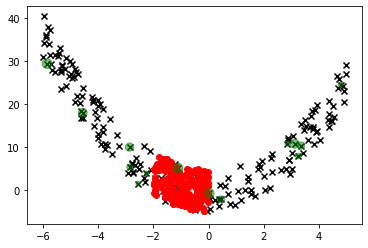

In [7]:
x1x2 = np.vstack((x1, x2))
sig2 = general_utils.meddistance(x1x2, subsample=1000)
print(sig2)
k = kernel_utils.KGauss(sig2)

coef, _ = tst.WQuadMMDTest.kernel_mean_matching(x2, x1, k, B=10)

plt.close()
plt.figure()
plt.scatter(x1[:, 0], x1[:, 1], color='black', marker='x')
plt.scatter(x2[:, 0], x2[:, 1], color='red')
plt.scatter(x1[:, 0], x1[:, 1], color='green', s=coef * 10, alpha=0.5)

Lets see if we can make inference that incorporates this idea automatically

## The WMMD test
Let us first initialize some reasonable length scales for our kernels and divide our data into training and testing sets to optimize these parameters further. Then, we will optimize the test hyperparameters fro best performance and perform a test with permutations.

In [11]:
# REformat data and split into training and testing for hyperparameter optimization
tst_data = data.WTSTData(x1[:, 0][:,np.newaxis], x2[:, 0][:,np.newaxis], x1[:, 1][:,np.newaxis], x2[:, 1][:,np.newaxis])
tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=10)
y1y2 = tr.stack_y1y2()
x1x2 = tr.stack_x1x2()
sig2y = general_utils.meddistance(y1y2, subsample=1000)
sig2x = general_utils.meddistance(x1x2, subsample=1000)
print(sig2y)
print(sig2x)
k = kernel_utils.KGauss(sig2y)
kx = kernel_utils.KGauss(sig2x)

5.65846080647524
2.0354815196924565


In [12]:
# choose the best parameter and perform a test with permutations
med = general_utils.meddistance(tr.stack_y1y2(), 1000)
alpha = 0.01
list_gwidth = np.hstack( ( (med**2) *(2.0**np.linspace(-4, 4, 20) ) ) )
list_gwidth.sort()

list_kernels = [kernel_utils.KGauss(gw2) for gw2 in list_gwidth]

# grid search to choose the best Gaussian width
besti, powers = tst.WQuadMMDTest.grid_search_kernel(tr, list_kernels, kx, alpha)
best_ker = list_kernels[besti]

Now, having computed the optimal hyperparameters we run our test on the testing subset

In [13]:
start = time.time()
mmd_test = tst.WQuadMMDTest(best_ker, kx, n_permute=200, alpha=alpha)
test_result = mmd_test.perform_test(te)
end = time.time()
print('WMMD test took: %s seconds'%(end-start))
test_result

WMMD test took: 1.144334316253662 seconds


{'alpha': 0.01,
 'pvalue': 0.71,
 'test_stat': -0.029330621330246165,
 'h0_rejected': False}

We can compare this with a conventional MMD statistic to see the difference.
Here also we will run the MMD on the subset of data that overlaps, i.e. the examples that are actually comparable, to find that it gives the same conclusions as the WMMD.

In [10]:
alpha = 0.01

print('WMMD results:', tst.run_full_WMMD_test(x2[:, 0][:,np.newaxis], x1[:, 0][:,np.newaxis], 
                                              x2[:, 1][:,np.newaxis], x1[:, 1][:,np.newaxis]))
print('MMD results:', tst.run_full_MMD_test(x2[:, 0][:,np.newaxis], x1[:, 0][:,np.newaxis], 
                                            x2[:, 1][:,np.newaxis], x1[:, 1][:,np.newaxis]))
print('WMMD results:', tst.run_full_WMMD_test(x2_bis[:, 0][:,np.newaxis], x1_bis[:, 0][:,np.newaxis], 
                                              x2_bis[:, 1][:,np.newaxis], x1_bis[:, 1][:,np.newaxis]))
print('MMD results:', tst.run_full_MMD_test(x2_bis[:, 0][:,np.newaxis], x1_bis[:, 0][:,np.newaxis], 
                                            x2_bis[:, 1][:,np.newaxis], x1_bis[:, 1][:,np.newaxis]))

WMMD results: {'alpha': 0.01, 'pvalue': 0.835, 'test_stat': 0.1525498388153575, 'h0_rejected': False}
MMD results: {'alpha': 0.01, 'pvalue': 0.0, 'test_stat': 0.3536753867787228, 'h0_rejected': True}
WMMD results: {'alpha': 0.01, 'pvalue': 0.535, 'test_stat': -0.002137621675497886, 'h0_rejected': False}
MMD results: {'alpha': 0.01, 'pvalue': 0.715, 'test_stat': -0.004292698345838342, 'h0_rejected': False}


In [14]:
print('WMMD results:', tst.run_full_WMMD_test(x1[:, 0][:,np.newaxis], x2[:, 0][:,np.newaxis], 
                                              x1[:, 1][:,np.newaxis], x2[:, 1][:,np.newaxis]))
print('WMMD results:', tst.run_full_WMMD_test(x2[:, 0][:,np.newaxis], x1[:, 0][:,np.newaxis], 
                                              x2[:, 1][:,np.newaxis], x1[:, 1][:,np.newaxis]))

WMMD results: {'alpha': 0.01, 'pvalue': 0.99, 'test_stat': -0.06483313811864999, 'h0_rejected': False}
WMMD results: {'alpha': 0.01, 'pvalue': 0.79, 'test_stat': 0.1525498388153575, 'h0_rejected': False}
